In [1]:
#importing the libraries
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout ,  GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing import image
import cv2
import sys

Using TensorFlow backend.


## Data preparation

In [2]:
#load the cifar10 dataset from keras
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()#split the data set into train and test
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))#get the number of classes

170500096/170498071 [==============================] - 2s 0us/step


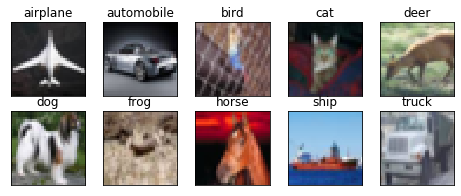

In [3]:
#get class name
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    #plot the images.
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
#function to plot model's history
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
#convert to 'float32' and divide by 255 to scale it in [0,1]
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:

def gradCAM(img, model, layer_name):
  class_idx = np.argmax(model.predict(img)[0])
  
  class_output = model.output[:, class_idx]
  layer = model.get_layer(layer_name)
  
  grads = K.gradients(class_output, layer.output)[0]
  pooled_grads = K.mean(grads, axis = (0, 1, 2))
  
  iterate = K.function([model.input],[pooled_grads, layer.output[0]])
  
  pooled_grads_val, layer_output_val = iterate([img])
  
  
  for i in range(pooled_grads_val.shape[0]):
    layer_output_val[:,:,i] *= pooled_grads_val[i]
  
  heatmap = np.sum(layer_output_val, axis = 2)
  heatmap = np.maximum(heatmap, 0)
  
  heatmap /= np.max(heatmap)
  
  heatmap = cv2.resize(heatmap, (32,32))
  heatmap = np.uint8(heatmap * 255)

  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_RAINBOW)
    
  return heatmap
  
  

In [0]:
# Define the model
def get_model():
  model = Sequential()

  model.add(Convolution2D(48, 3, 3, border_mode='same', input_shape=(32, 32, 3)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Convolution2D(48, 3, 3))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))

  model.add(Convolution2D(48, 1,border_mode='same'))
  model.add(Activation('relu'))

  model.add(MaxPooling2D(pool_size=(2, 2)))


  model.add(Convolution2D(96, 3, 3, border_mode='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Convolution2D(96, 3, 3))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))

  model.add(Convolution2D(96, 1,border_mode='same'))
  model.add(Activation('relu'))

  model.add(MaxPooling2D(pool_size=(2, 2)))


  model.add(Convolution2D(192, 3, 3, border_mode='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Convolution2D(192, 3, 3))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))

  model.add(Convolution2D(192, 1,border_mode='same'))
  model.add(Activation('relu'))

  model.add(MaxPooling2D(pool_size=(2, 2)))


  model.add(Convolution2D(num_classes, 2))
  
  model.add(GlobalAveragePooling2D())

  model.add(Activation('softmax'))

  return model

## Model without Cutout

In [9]:
model=get_model()
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  after removing the cwd from sys.path.







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, 1, padding="same")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, 1, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, (3, 3), padding="same")`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, 1, padding="same")`


In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 48)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 48)        192       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 48)        20784     
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 48)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 48)       

In [11]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

train_datagen = ImageDataGenerator(featurewise_center = True, 
                                   featurewise_std_normalization = True,
                                   rotation_range = 10,
                                   zoom_range = 0.10,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                  fill_mode="nearest")
test_datagen = ImageDataGenerator(featurewise_center = True, featurewise_std_normalization = True)
train_datagen.fit(train_features)
test_datagen.fit(test_features)

train_data_iter = train_datagen.flow(train_features,train_labels, batch_size = 128)
test_data_iter =  test_datagen.flow(test_features,test_labels, batch_size = 10000)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

CKPT = ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)
start = time.time()
model_info = model.fit_generator(train_data_iter,
                                 steps_per_epoch = 1000, nb_epoch = 50, 
                                 validation_data = test_data_iter.next(), verbose=1, callbacks = [CKPT])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=1000, validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., epochs=50)`




Epoch 1/50
1000/1000 [==============================] - 115s 115ms/step - loss: 1.2592 - acc: 0.5509 - val_loss: 1.0272 - val_acc: 0.6477

Epoch 00001: val_acc improved from -inf to 0.64770, saving model to best_model.hdf5
Epoch 2/50
1000/1000 [==============================] - 109s 109ms/step - loss: 0.7978 - acc: 0.7202 - val_loss: 0.8086 - val_acc: 0.7298

Epoch 00002: val_acc improved from 0.64770 to 0.72980, saving model to best_model.hdf5
Epoch 3/50
1000/1000 [==============================] - 109s 109ms/step - loss: 0.6511 - acc: 0.7738 - val_loss: 0.9275 - val_acc: 0.7096

Epoch 00003: val_acc did not improve from 0.72980
Epoch 4/50
1000/1000 [==============================] - 110s 110ms/step - loss: 0.5560 - acc: 0.8061 - val_loss: 0.7258 - val_acc: 0.7744

Epoch 00004: val_acc improved from 0.72980 to 0.77440, saving model to best_model.hdf5
Epoch 5/50
1000/1000 [==============================] - 109s 109ms/step - loss: 0.5015 - acc: 0.8242 - val_loss: 0.5607 - val_acc: 0.8

In [12]:
# plot model history
#plot_model_history(model)

# compute test accuracy
model.load_weights('./best_model.hdf5')
test_features_n, test_labels_n = test_data_iter.next()
print ("Accuracy on test data is: %0.2f"%accuracy(test_features_n, test_labels_n, model))

Accuracy on test data is: 88.65


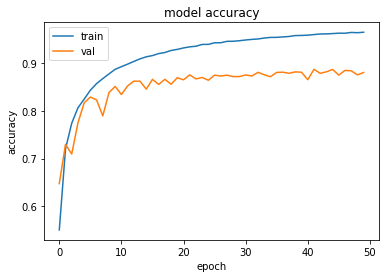

In [13]:
# summarize history for accuracy
plt.plot(model_info.history['acc'])
plt.plot(model_info.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

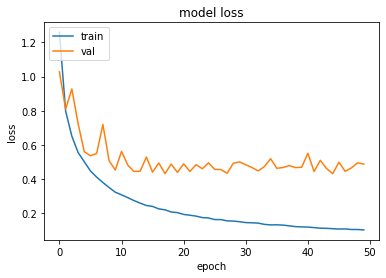

In [14]:
# summarize history for loss
plt.plot(model_info.history['loss'])
plt.plot(model_info.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**We can clearly see that we have resolved the problem of overfitting,and our model is generalizing well on test data**

In [0]:
(train_features_1, train_labels_1), (test_features_1, test_labels_1) = cifar10.load_data()
test_features_scaled = test_features_1.astype('float32')/255
test_labels_1 = np_utils.to_categorical(test_labels_1, num_classes)
test_datagen.fit(test_features_scaled)
#test_data_iter =  test_datagen.flow(test_features_scaled,test_labels_1, batch_size = 10000)
test_features = test_datagen.standardize(test_features_scaled)

In [0]:
actuals = np.argmax(test_labels_1, axis = 1)
preds = np.argmax(model.predict(test_features), axis = 1)

correct_idx = [idx for idx in range(10000) if actuals[idx] == preds[idx]]
#incorrect_idx = [idx for idx in range(10000) if idx not in correct_idx]

correct_plot_idx = np.random.choice(correct_idx, size = 12, replace = False)
#incorrect_plot_idx = np.random.choice(incorrect_idx, size = 12, replace = False)

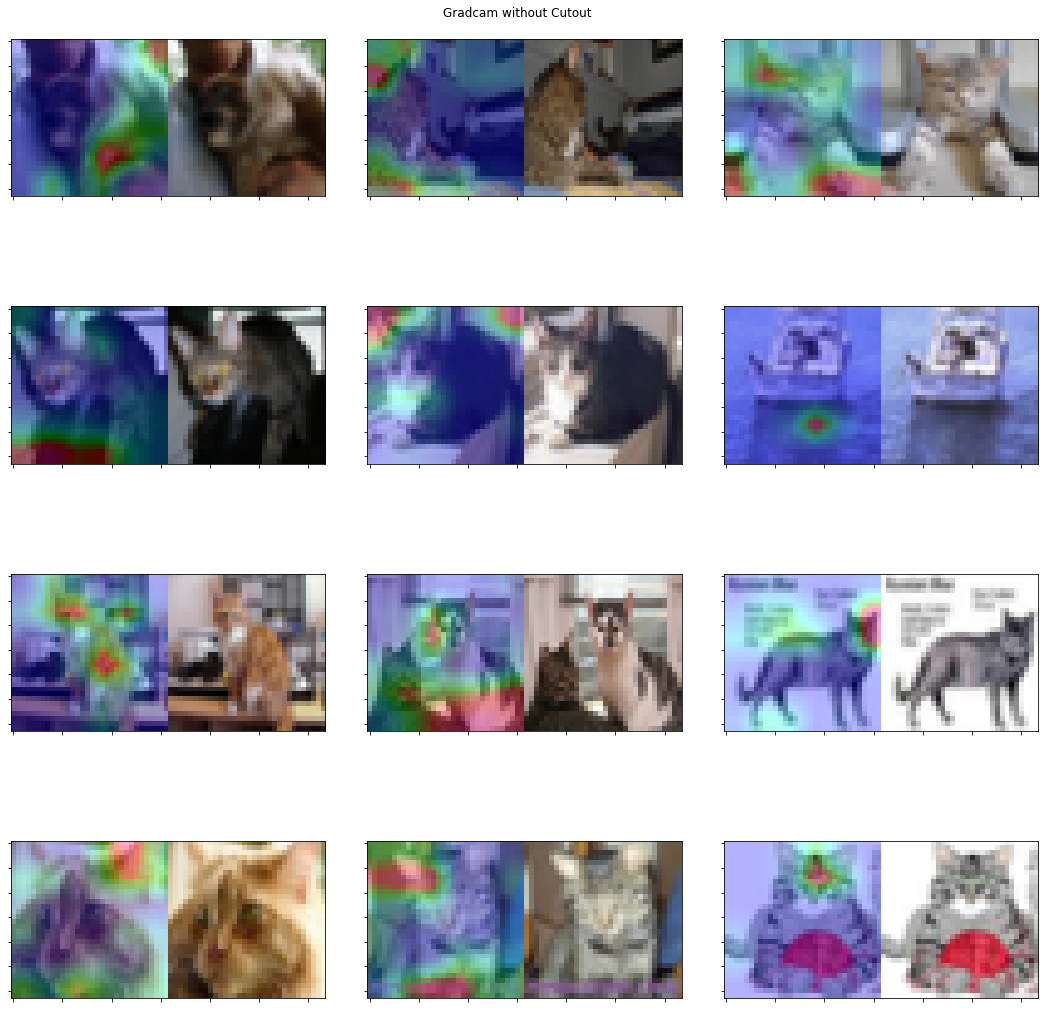

In [32]:
fig, ax = plt.subplots(4,3, figsize = (15,15))
fig.tight_layout()
fig.suptitle("Gradcam without Cutout")

plot_idx = 0

for i in range(4):
  for j in range(3):
    img = test_features[correct_plot_idx[plot_idx]].reshape([-1,32,32,3])
    
    unnormalized_img = test_features_1[correct_plot_idx[plot_idx]]
    
    heatmap = gradCAM(img, model, "conv2d_7")
    superimposed_img = cv2.addWeighted(unnormalized_img, 0.7, heatmap, 0.3, 0, dtype = cv2.CV_32F)/255
    
    true_class = class_names[actuals[correct_plot_idx[plot_idx]]]
    pred_class = class_names[preds[correct_plot_idx[plot_idx]]]
    plot_idx += 1
    plot_img = np.concatenate((superimposed_img, unnormalized_img/255), axis = 1)
    ax[i, j].imshow(plot_img)
    ax[i, j].set_xticklabels([])
    ax[i, j].set_yticklabels([])
    #ax[i, j].set_title("Actual : {}, Pred : {}".format(true_class, pred_class))
    
    
plt.show()

**This is the heatmap from conv2d_7 layer.Because the subsequent convolution layers has less than 5x5 resolution.**

In [0]:
def get_cutout_fn(min_area_ratio, max_area_ratio):
  area_ratio = np.random.uniform(min_area_ratio, max_area_ratio)
  def cutout(X):
    
    H, W, C = X.shape
    
    img_area = H*W
    cutout_area = img_area * area_ratio
    
    
    max_aspect_ratio = max([(H*H)/cutout_area,cutout_area/(W*W)])
    min_aspect_ratio = min([(H*H)/cutout_area,cutout_area/(W*W)])
    
    aspect_ratio = np.random.uniform(min_aspect_ratio, max_aspect_ratio)
    
    cutout_width = int(np.ceil(np.sqrt(cutout_area/aspect_ratio)))
    cutout_height = int(np.ceil(np.sqrt(cutout_area*aspect_ratio)))
    
    if cutout_height == 32:
      top = 0
    else:
      top = np.random.randint(0, H - cutout_height)  
    
    if cutout_width == 32:
      left = 0
    else:
      left = np.random.randint(0, W - cutout_width)
    
    for c in range(C):
      mu = np.mean(X[top:top + cutout_height, left:left + cutout_width, c])
      X[top:top + cutout_height, left: left + cutout_width, c] = mu
      
      
    return X
    
    
  return cutout


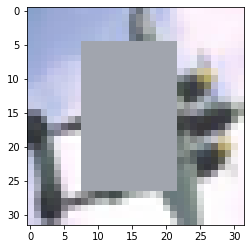

In [20]:
cutout_fn = get_cutout_fn(0.1, 0.3)
plt.imshow(cutout_fn(train_features[3466]))

### Model with Cutout

In [21]:
model_with_cutout=get_model()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, 1, padding="same")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, 1, padding

In [0]:
# Compile the model
model_with_cutout.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
model_with_cutout.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 48)        1344      
_________________________________________________________________
activation_11 (Activation)   (None, 32, 32, 48)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 48)        192       
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 30, 30, 48)        20784     
_________________________________________________________________
activation_12 (Activation)   (None, 30, 30, 48)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 30, 30, 48)       

In [24]:
train_datagen = ImageDataGenerator(featurewise_center = True, 
                                   featurewise_std_normalization = True,
                                   rotation_range = 10,
                                   zoom_range = 0.10,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   fill_mode="nearest",
                                   preprocessing_function = get_cutout_fn(0.1, 0.3))


test_datagen = ImageDataGenerator(featurewise_center = True, featurewise_std_normalization = True)
train_datagen.fit(train_features)
test_datagen.fit(test_features)

train_data_iter = train_datagen.flow(train_features,train_labels, batch_size = 128)
test_data_iter =  test_datagen.flow(test_features,test_labels, batch_size = 10000)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

CKPT = ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)
start = time.time()
model_info_with_cutout = model.fit_generator(train_data_iter,
                                 steps_per_epoch = 1000, nb_epoch = 50, 
                                 validation_data = test_data_iter.next(), verbose=1, callbacks = [CKPT])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=1000, validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., epochs=50)`


Epoch 1/50
1000/1000 [==============================] - 133s 133ms/step - loss: 0.7193 - acc: 0.7526 - val_loss: 0.4454 - val_acc: 0.8613

Epoch 00001: val_acc improved from -inf to 0.86130, saving model to best_model.hdf5
Epoch 2/50
1000/1000 [==============================] - 131s 131ms/step - loss: 0.5944 - acc: 0.7909 - val_loss: 0.4312 - val_acc: 0.8661

Epoch 00002: val_acc improved from 0.86130 to 0.86610, saving model to best_model.hdf5
Epoch 3/50
1000/1000 [==============================] - 130s 130ms/step - loss: 0.5570 - acc: 0.8040 - val_loss: 0.4348 - val_acc: 0.8640

Epoch 00003: val_acc did not improve from 0.86610
Epoch 4/50
1000/1000 [==============================] - 132s 132ms/step - loss: 0.5316 - acc: 0.8128 - val_loss: 0.5502 - val_acc: 0.8374

Epoch 00004: val_acc did not improve from 0.86610
Epoch 5/50
1000/1000 [==============================] - 131s 131ms/step - loss: 0.5191 - acc: 0.8168 - val_loss: 0.4547 - val_acc: 0.8615

Epoch 00005: val_acc did not impro

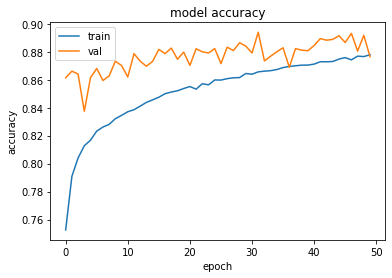

In [25]:
# summarize history for accuracy
plt.plot(model_info_with_cutout.history['acc'])
plt.plot(model_info_with_cutout.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

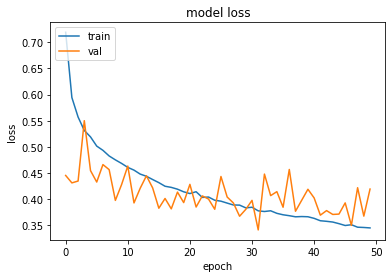

In [26]:
# summarize history for loss
plt.plot(model_info_with_cutout.history['loss'])
plt.plot(model_info_with_cutout.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**We can clearly observe that the accuracy increased with the introduction of cutout**

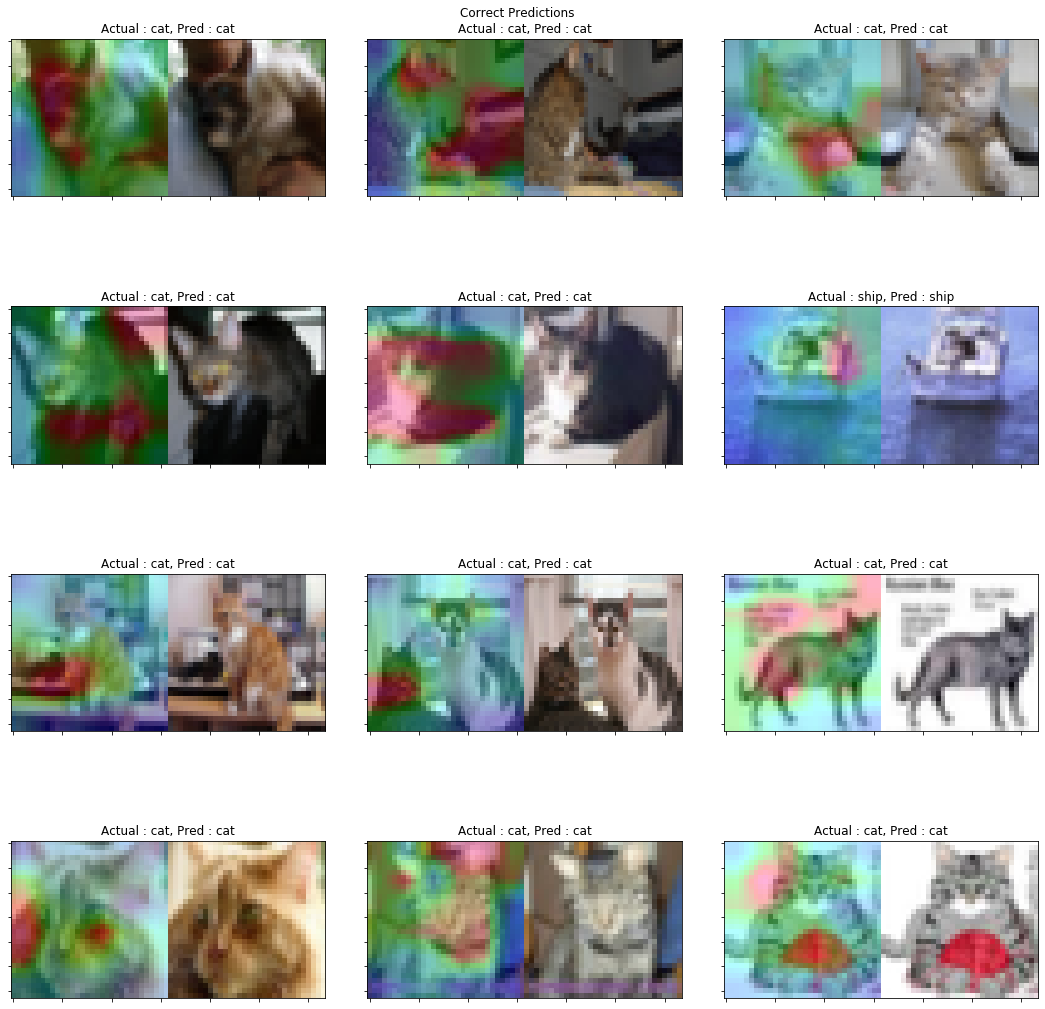

In [31]:
actuals = np.argmax(test_labels_1, axis = 1)
preds = np.argmax(model_with_cutout.predict(test_features), axis = 1)

correct_idx = [idx for idx in range(10000) if actuals[idx] == preds[idx]]
#incorrect_idx = [idx for idx in range(10000) if idx not in correct_idx]

correct_plot_idx = np.random.choice(correct_idx, size = 12, replace = False)
#incorrect_plot_idx = np.random.choice(incorrect_idx, size = 12, replace = False)

fig, ax = plt.subplots(4,3, figsize = (15,15))
fig.tight_layout()
fig.suptitle("Correct Predictions")

plot_idx = 0

for i in range(4):
  for j in range(3):
    img = test_features[correct_plot_idx[plot_idx]].reshape([-1,32,32,3])
    
    unnormalized_img = test_features_1[correct_plot_idx[plot_idx]]
    
    heatmap = gradCAM(img, model_with_cutout, "conv2d_17")
    
    superimposed_img = cv2.addWeighted(unnormalized_img, 0.7, heatmap, 0.3, 0, dtype = cv2.CV_32F)/255
    
    true_class = class_names[actuals[correct_plot_idx[plot_idx]]]
    pred_class = class_names[preds[correct_plot_idx[plot_idx]]]
    plot_idx += 1
    plot_img = np.concatenate((superimposed_img, unnormalized_img/255), axis = 1)
    ax[i, j].imshow(plot_img)
    ax[i, j].set_xticklabels([])
    ax[i, j].set_yticklabels([])
    ax[i, j].set_title("Actual : {}, Pred : {}".format(true_class, pred_class))

**This is the heatmap from conv2d_17 layer.Because the subsequent convolution layers has less than 5x5 resolution.**

**Observations**
* Gradcam works better with the state of art models.
* Use layer which have 5x5 or more resolution,othewise output(heatmap) would visually look like a colured filter on top of your original image.

### References

* http://www.hackevolve.com/where-cnn-is-looking-grad-cam/
* https://github.com/yu4u/cutout-random-erasing
* https://github.com/anubhavsatpathy/
*https://www.henryailabs.com/3-2-19.html